### 2D PIELM Simulation with one seismic sources 
- The algorithm uses 25% of gridpoints for traveltime and velocity collocation points
- The activation function is an adaptive sine activation function

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### 2D Domain Specification and Velocity Model
- Defines the spatial domain (2km × 2km) with grid resolution parameters
- Sets up a velocity model with vertical gradient for realistic wave propagation
- The source is positioned at the domain center (1km, 1km)

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Domain parameters
x_min, x_max = 0.0, 2.0  # km
z_min, z_max = 0.0, 2.0  # km
dx, dz = 0.02, 0.02  # km (20m)
nx, nz = 101, 101  # grid points
source_x, source_z = 1.0, 1.0  # km

# Velocity model parameters
v0 = 2.0  # km/s at surface
vertgrad = 0.5  # s^{-1}
horigrad = 0.0

# Generate grid coordinates
x = torch.linspace(x_min, x_max, nx, device=device)
z = torch.linspace(z_min, z_max, nz, device=device)
X, Z = torch.meshgrid(x, z, indexing='ij')
coords = torch.stack((X.flatten(), Z.flatten()), dim=1)

v_ref = v0 + vertgrad * source_z + horigrad * source_x

velmodel = v_ref + vertgrad*(X-source_x) + horigrad*(Z-source_z);

Using device: cpu


### Initial Velocity Model with Source Location Visulization

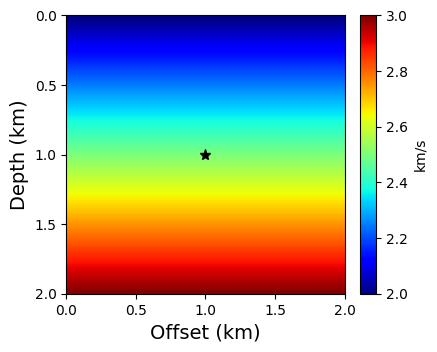

In [3]:
# Plot the velocity model with the source location
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")

ax.plot(source_x, source_z,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

#plt.savefig("./velmodel.pdf", format='pdf', bbox_inches="tight")
     

### Reference and Analytical Traveltime Computations
- `T0`: Reference traveltime field for training
- `T_data`: Exact analytical solution for 2D geophysical model
- These serve as training reference and ground truth validation, respectively

In [4]:
# Analytical solution for reference traveltime field T0
def calculate_T0(x, z, xs, zs, v_ref):
    r = torch.sqrt((x - xs)**2 + (z - zs)**2)
    return r / v_ref

T0 = calculate_T0(X, Z, source_x, source_z, v_ref)

# Calculate analytical traveltime T_data
if vertgrad == 0 and horigrad == 0:
    T_data = torch.sqrt((X - source_x)**2 + (Z - source_z)**2) / v0
else:
    # Corrected analytical solution
    r_sq = (X - source_x)**2 + (Z - source_z)**2
    # Convert denominator to tensor
    denom = torch.sqrt(torch.tensor(vertgrad**2 + horigrad**2, device=device))
    term = 1.0 + 0.5 * (vertgrad**2 + horigrad**2) * r_sq / (v_ref * velmodel)
    # Clamp to avoid numerical issues
    term = torch.clamp(term, min=1.0 + 1e-8)
    T_data = torch.arccosh(term) / denom
    
# Prepare training data
# Calculate indices directly without tensors
i = int(round((source_x - x_min) / dx))
j = int(round((source_z - z_min) / dz))
source_index = i * nz + j
all_indices = torch.arange(nx * nz, device=device)
non_source_indices = all_indices[all_indices != source_index]

# Sample sparse velocity points (25% of grid, including source)
num_vel_points = 2500
vel_indices = torch.cat([
    torch.tensor([source_index], device=device),
    non_source_indices[torch.randperm(len(non_source_indices))[:num_vel_points - 1]]
])
vel_coords = coords[vel_indices]
vel_true = velmodel.flatten()[vel_indices].unsqueeze(1)

# Collocation points (25% of grid, excluding source)
num_collocation_points = 2500
collocation_indices = non_source_indices[torch.randperm(len(non_source_indices))[:num_collocation_points]]
collocation_coords = coords[collocation_indices]

# Source coordinates
source_coords_tensor = torch.tensor([[source_x, source_z]], dtype=torch.float32, device=device)

# Precompute T0 and its gradients at collocation points WITH GRAD ENABLED
# Create temporary copy for precomputation
temp_coords = collocation_coords.clone().requires_grad_(True)
T0_col = calculate_T0(
    temp_coords[:, 0], 
    temp_coords[:, 1],
    source_x,
    source_z,
    v_ref
)

# Compute gradients WITH create_graph=False
grad_T0 = torch.autograd.grad(
    T0_col, temp_coords,
    grad_outputs=torch.ones_like(T0_col),
    create_graph=False,
    retain_graph=False
)[0]
dT0dx, dT0dz = grad_T0[:, 0], grad_T0[:, 1]

# Detach and store for later use
T0_col = T0_col.detach()
dT0dx = dT0dx.detach()
dT0dz = dT0dz.detach()

# PIELM Architecture (SIREN)
The Physics-Informed Extreme Learning Machine uses Sine Activation (SIREN):
- Custom neural network uses an adaptive sine activation functions and SIREN-inspired initialization
- `self.hidden.requires_grad_(False)` frozen hidden layer weights
- Architecture: 2000 hidden units
- Configures Adam optimizer with learning rate scheduler for adaptive training
- Computes traveltime gradients via automatic differentiation
- Constraints source location with u=1 for boundary loss `loss_bc`

In [5]:
#sin Activation functioon
import math
import time
start_time = time.time()

class A_ELM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(A_ELM, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, 1)
        
        # SIREN-inspired initialization
        omega_0 = 420.0
        bound = math.sqrt(6.0 / input_size) / omega_0
        nn.init.uniform_(self.hidden.weight, -bound, bound)
        nn.init.uniform_(self.hidden.bias, -bound, bound)
        self.hidden.requires_grad_(False)  # Freeze hidden weights
        
        # Trainable slope parameters initialized at 30
        self.a = nn.Parameter(30.0 * torch.ones(hidden_size))
        
    def forward(self, x):
        linear = self.hidden(x)
        activated = torch.sin(self.a * linear)  # Sinusoidal activation
        raw = self.output_layer(activated)
        return torch.exp(raw)  # Ensures positive output
        
# Initialize ELM
hidden_size = 2000

# Initialize separate networks
elm_u = A_ELM(2, hidden_size).to(device)
elm_v = A_ELM(2, hidden_size).to(device)

# Loss coefficients
lambda_bc = 1e4    # Boundary loss weight
lambda_vel = 1e2   # Velocity data loss weight
lambda_pde = 1e1   # Physics loss weight


# Training loop
num_epochs = 10000
loss_history = []

# Optimizer (only output layer)
# Combined optimizer
optimizer = optim.Adam(
    [
        {'params': elm_u.output_layer.parameters()},
        {'params': elm_u.a},  # Include slope parameters
        {'params': elm_v.output_layer.parameters()},
        {'params': elm_v.a}
    ],
    lr=0.0005
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=100
)


for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Boundary condition (u-network)
    u_pred_src = elm_u(source_coords_tensor)
    loss_bc = (u_pred_src - 1.0)**2
    
    # Velocity data (v-network)
    v_pred_vel = elm_v(vel_coords)
    loss_vel = torch.mean((v_pred_vel - vel_true)**2)
    
    # Physics coupling (joint)
    # Create fresh tensor with gradients enabled
    epoch_colloc = collocation_coords.detach().clone().requires_grad_(True)
    u_pred_col = elm_u(epoch_colloc)
    v_pred_col = elm_v(epoch_colloc)
    
    # Compute u gradients
    grad_u = torch.autograd.grad(
        u_pred_col, epoch_colloc, 
        grad_outputs=torch.ones_like(u_pred_col),
        create_graph=True
    )[0]
    dudx, dudz = grad_u[:, 0:1], grad_u[:, 1:2]
    
    # Shared eikonal residual
    dTdx = u_pred_col * dT0dx.unsqueeze(1) + T0_col.unsqueeze(1) * dudx
    dTdz = u_pred_col * dT0dz.unsqueeze(1) + T0_col.unsqueeze(1) * dudz
    pde_residual = dTdx**2 + dTdz**2 - 1/(v_pred_col**2)
    loss_pde = torch.mean(pde_residual**2)

    # Combined loss
    total_loss = lambda_bc*loss_bc + lambda_vel*loss_vel + lambda_pde*loss_pde
    total_loss.backward()
    optimizer.step()
    scheduler.step(total_loss)
    loss_history.append(total_loss.item())
    
    if epoch % 100 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.6f}, LR = {current_lr:.2e}")

elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))


Epoch 0/10000, Loss: 251.652710, LR = 5.00e-04
Epoch 100/10000, Loss: 0.030288, LR = 5.00e-04
Epoch 200/10000, Loss: 0.024203, LR = 5.00e-04
Epoch 300/10000, Loss: 0.022127, LR = 5.00e-04
Epoch 400/10000, Loss: 0.020756, LR = 5.00e-04
Epoch 500/10000, Loss: 0.019851, LR = 5.00e-04
Epoch 600/10000, Loss: 0.019230, LR = 5.00e-04
Epoch 700/10000, Loss: 0.018801, LR = 5.00e-04
Epoch 800/10000, Loss: 0.018515, LR = 5.00e-04
Epoch 900/10000, Loss: 0.018333, LR = 5.00e-04
Epoch 1000/10000, Loss: 0.018223, LR = 5.00e-04
Epoch 1100/10000, Loss: 0.018159, LR = 5.00e-04
Epoch 1200/10000, Loss: 0.018122, LR = 5.00e-04
Epoch 1300/10000, Loss: 0.904517, LR = 5.00e-04
Epoch 1400/10000, Loss: 0.018116, LR = 5.00e-04
Epoch 1500/10000, Loss: 0.018072, LR = 5.00e-04
Epoch 1600/10000, Loss: 0.023820, LR = 5.00e-04
Epoch 1700/10000, Loss: 0.018049, LR = 5.00e-04
Epoch 1800/10000, Loss: 0.383092, LR = 5.00e-04
Epoch 1900/10000, Loss: 0.018164, LR = 5.00e-04
Epoch 2000/10000, Loss: 0.018010, LR = 5.00e-04
Ep

### PIELM Prediction and Result Preparation
- Evaluates trained models on the entire 2D grid to predict velocity and traveltime fields. 
- Computes predicted traveltime `T_pred` as T = T0 × u and converts results to numpy arrays for visualization and comparison.

In [6]:
# Predict on entire domain
with torch.no_grad():
    u_pred = elm_u(coords).reshape(nx, nz).cpu().numpy()
    v_pred = elm_v(coords).reshape(nx, nz).cpu().numpy()
    T_pred = T0.cpu().numpy() * u_pred

In [7]:
# Analytical solutions for comparison
T0_np = T0.cpu().numpy()
T_data_np = T_data.cpu().numpy()
velmodel_np = velmodel.cpu().numpy()

### Results Visualization
- True vs predicted velocity fields
- Analytical vs predicted traveltime fields
- Calculates and visualizes absolute errors for both velocity and traveltime predictions


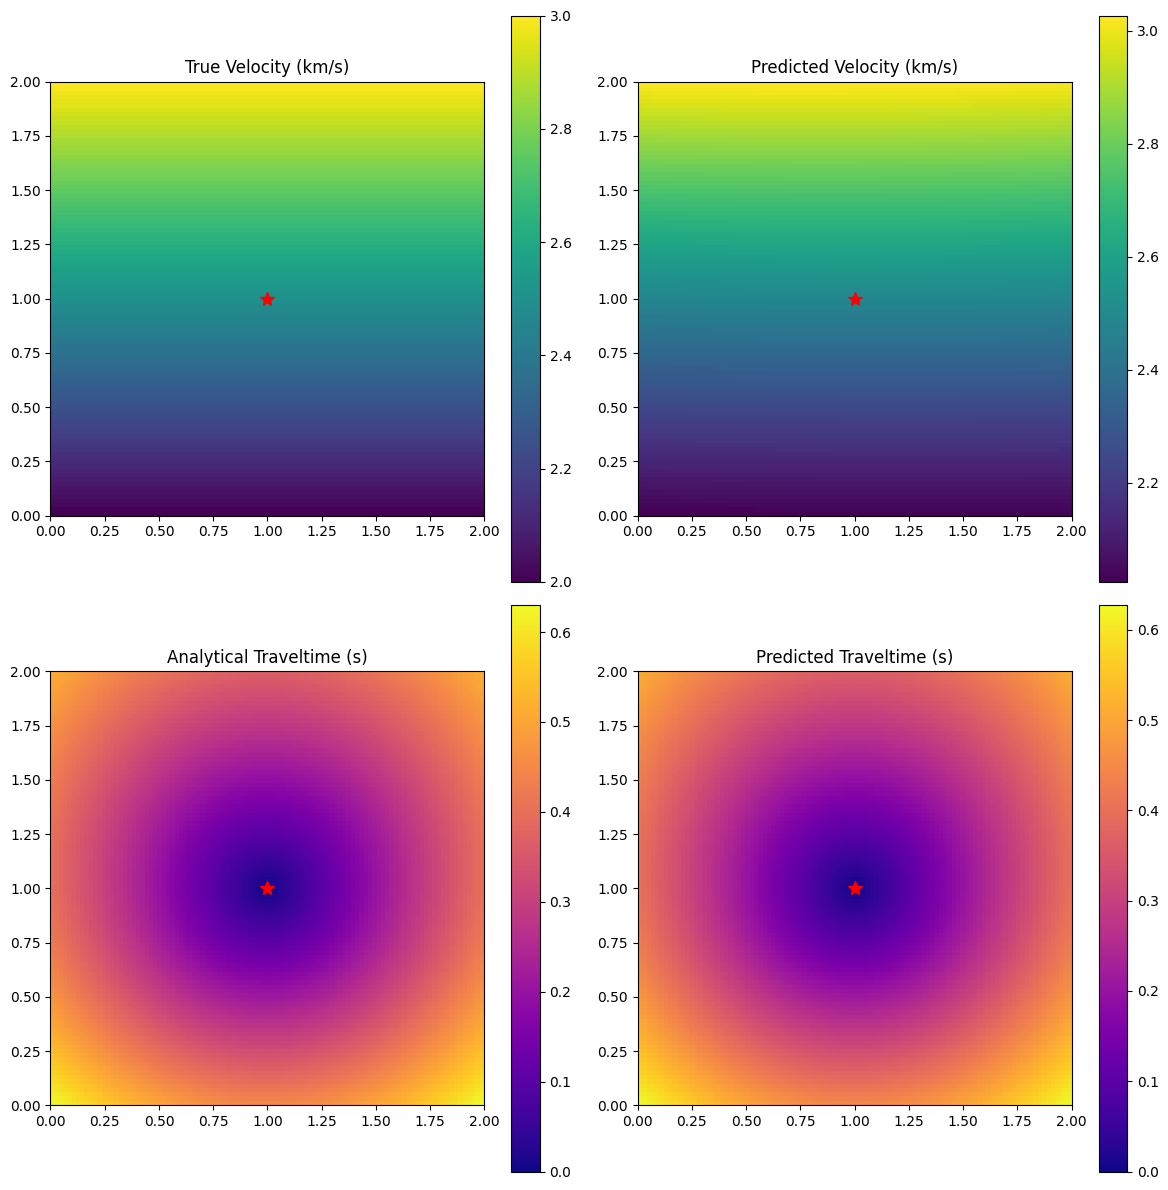

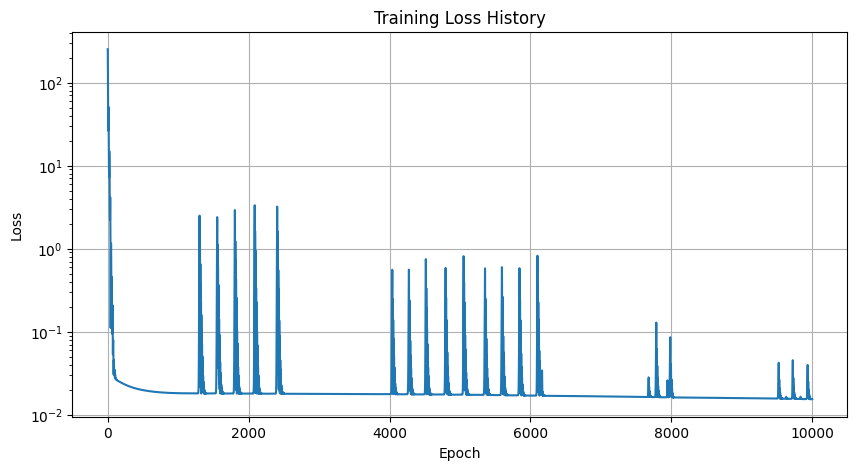

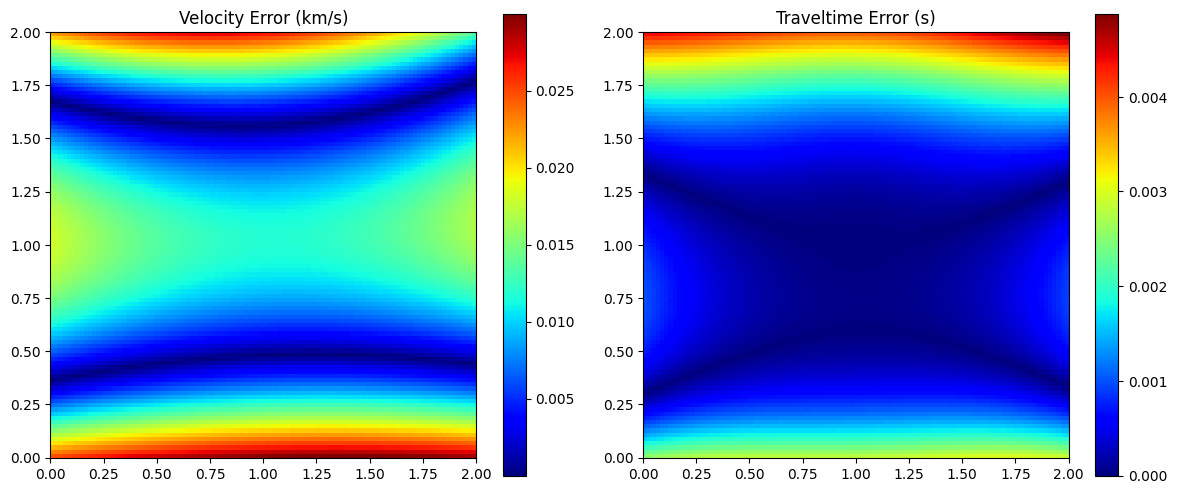

In [15]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# True velocity
im0 = axes[0, 0].imshow(velmodel_np, origin='lower', extent=[x_min, x_max, z_min, z_max], cmap='viridis')
axes[0, 0].plot(source_x, source_z, 'r*', markersize=10)
axes[0, 0].set_title("True Velocity (km/s)")
fig.colorbar(im0, ax=axes[0, 0])

# Predicted velocity
im1 = axes[0, 1].imshow(v_pred, origin='lower', extent=[x_min, x_max, z_min, z_max], cmap='viridis')
axes[0, 1].plot(source_x, source_z, 'r*', markersize=10)
axes[0, 1].set_title("Predicted Velocity (km/s)")
fig.colorbar(im1, ax=axes[0, 1])

# True traveltime
im2 = axes[1, 0].imshow(T_data_np, origin='lower', extent=[x_min, x_max, z_min, z_max], cmap='plasma')
axes[1, 0].plot(source_x, source_z, 'r*', markersize=10)
axes[1, 0].set_title("Analytical Traveltime (s)")
fig.colorbar(im2, ax=axes[1, 0])

# Predicted traveltime
im3 = axes[1, 1].imshow(T_pred, origin='lower', extent=[x_min, x_max, z_min, z_max], cmap='plasma')
axes[1, 1].plot(source_x, source_z, 'r*', markersize=10)
axes[1, 1].set_title("Predicted Traveltime (s)")
fig.colorbar(im3, ax=axes[1, 1])

plt.tight_layout()
plt.savefig("elm_results.png")
plt.show()


# Plot loss history
plt.figure(figsize=(10, 5))
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.savefig("elm_loss_history.png")
plt.show()
# Export loss history as .npy file
np.save("loss_history_sin.npy", np.array(loss_history))
# Error plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Velocity error
im0 = axes[0].imshow(np.abs(v_pred - velmodel_np), origin='lower', 
                    extent=[x_min, x_max, z_min, z_max], cmap='jet')
axes[0].set_title("Velocity Error (km/s)")
fig.colorbar(im0, ax=axes[0])

# Traveltime error
im1 = axes[1].imshow(np.abs(T_pred - T_data_np), origin='lower', 
                    extent=[x_min, x_max, z_min, z_max], cmap='jet')
axes[1].set_title("Traveltime Error (s)")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
#plt.savefig("elm_errors.png")
plt.savefig("./images/elmSin_errors.png", dpi=600, format='png', bbox_inches="tight")
plt.show()


### Absolute Error Analysis and FSM Comparison
- Loads and compares results with Fast Sweeping Method (FSM)
solution, providing benchmark comparison against traditional numerical methods

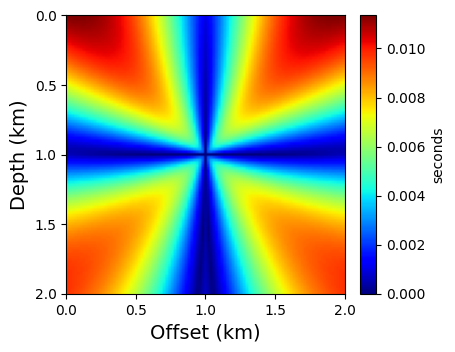

In [9]:
# Load and interpolate FSM solution
T_fsm = np.load('./traveltimes/Tcomp.npy')


# Plot the first order FSM solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_fsm-T_data_np), extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")
#cmap=jet, rainbow, seismic, plasma, coolwarm

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)

cbar.ax.tick_params(labelsize=10)

#plt.savefig("./fsmerror.pdf", format='pdf', bbox_inches="tight")

### Multi-Method Traveltime Validation
- **Analytical solution** (red solid lines): Exact solution `T_data_np`
- **PIELM prediction** (black dashed lines): Neural network results `T_pred`
- **FSM solution** (cyan dotted lines): Traditional numerical method `T_fsm`
- Visualizes wavefront shapes and method consistency through contour alignment.

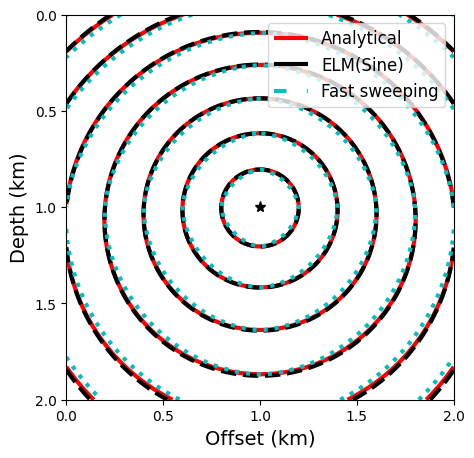

In [14]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_data_np, 8, extent=[x_min,x_max,z_min,z_max], colors='r', linewidths = 3)
im2 = ax.contour(T_pred, 8, extent=[x_min,x_max,z_min,z_max], colors='k',linestyles = 'dashed', linewidths = 3)
im3 = ax.contour(T_fsm, 8, extent=[x_min,x_max,z_min,z_max], colors='c',linestyles = 'dotted', linewidths = 3)

ax.plot(source_x, source_z,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'ELM(Sine)', 'Fast sweeping'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig("./images/ELM_Sin.png", dpi=600, format='png', bbox_inches="tight")